# Nuestras Caras

Entrenamiento del modelo (Red Neuronal) mediante la función 'backpropagation_2_layers' del script 'backpropagation.py'.

## Importar librerías para ejecutar notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import re

In [3]:
# Preparar las imagenes para ejecucion de la notebook (DEJAR EN FALSE)
PREPARAR_IMAGENES = False


import os
import sys

# Obtener el path de ejecucion de la notebook
current_dir = os.getcwd()

# Define el nombre del proyecto
root_dir_name = "NuestrasCaras"

# Obtiene el path del proyecto
while not os.path.basename(current_dir) == root_dir_name:
    current_dir = os.path.dirname(current_dir)
    
# Obtiene el path de las funciones para 
dir_func_00 = os.path.join(current_dir,"00_preparar_imagenes_entrenamiento")
dir_func_01 = os.path.join(current_dir,"01_entrenar_modelo")
dir_func_02 = os.path.join(current_dir,"02_probar_nuevas_fotos")
dir_func_03 = os.path.join(current_dir,"03_pruebas_entrenamiento_tensorflow")

# Agrega path a librerias
sys.path.append(current_dir)
sys.path.append(dir_func_00)
sys.path.append(dir_func_01)
sys.path.append(dir_func_02)
sys.path.append(dir_func_03)



if PREPARAR_IMAGENES:
    from preparar_imagenes import preparar_imagenes_entrenamiento
    dir_imagenes_input_entrenamiento = os.path.join(current_dir,"00_preparar_imagenes_entrenamiento", "imagenes_input_entrenamiento")
    dir_imagenes_output_entrenamiento = os.path.join(current_dir,"01_entrenar_modelo", "fotos_entrenamiento")
    preparar_imagenes_entrenamiento(dir_imagenes_input_entrenamiento, dir_imagenes_output_entrenamiento)

## Importar imagenes para entrenamiento modelo

In [4]:
# Configuración inicial
data_dir = ("fotos_entrenamiento")  # Cambia esto a la ruta de tu directorio de imágenes
nombres = []
imagenes = []

# Cargar imágenes y etiquetas
for archivo in os.listdir(data_dir):
    if archivo.endswith('.jpeg') or archivo.endswith('.jpg'):
        nombre = archivo.split('_')[0].replace(".jpg","").replace(".jpeg","")
        nombre = re.sub(r'\d+', '', nombre)
        ruta_imagen = os.path.join(data_dir, archivo)
        imagen = Image.open(ruta_imagen)
        imagen = np.array(imagen.resize((30, 30)))  # Redimensionar imágenes para un tamaño uniforme
        if len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises si es necesario
        imagenes.append(imagen.flatten())
        nombres.append(nombre)

new_images = np.array(imagenes)
nombres_new = np.array(nombres)

# estand
new_images = new_images/255.0

In [5]:
greyscale_values = pd.DataFrame(new_images)
people_names = nombres_new.reshape(-1)

## Dividir en train y test

In [6]:
# Mediante el parametro "stratify" nos aseguramos que se tomen todos los nombres
X_train, X_test, nombres_y_train, nombres_y_test = train_test_split(greyscale_values, people_names, test_size=0.2, random_state=42, stratify=people_names)

# Transformo los nombres a números (0-1) usando label binarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(nombres_y_train)
y_test = label_binarizer.transform(nombres_y_test)
classes = label_binarizer.classes_

In [7]:
# Train
print(X_train.shape)
print(nombres_y_train.shape)


(8367, 900)
(8367,)


In [8]:
# Test
print(X_test.shape)
print(nombres_y_test.shape)


(2092, 900)
(2092,)


In [9]:
# Dimensiones del array
people_names = np.array(people_names)
print(people_names.shape)

greyscale_values = np.array(greyscale_values)
print(greyscale_values.shape)

(10459,)
(10459, 900)


Text(0.5, 1.0, 'joaquin')

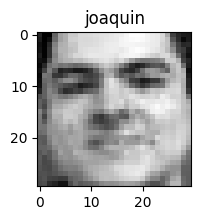

In [10]:
# prueba primera cara leida
plt.figure(figsize=(3, 2))
plt.imshow(np.array(X_train.iloc[0]).reshape(30,30),cmap="gray")
plt.title(nombres_y_train[0])

Text(0.5, 1.0, 'Cara Promedio')

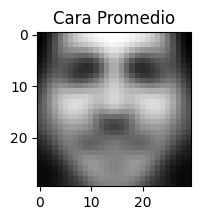

In [11]:
# obtiene y mustra la cara promedio
cara_promedio = np.mean(greyscale_values, axis=0)
cara_promedio.shape
plt.figure(figsize=(3, 2))
plt.imshow(cara_promedio.reshape(30,30),cmap="gray")
plt.title('Cara Promedio')

## Aplicar Análisis de Componentes Principales (PCA)

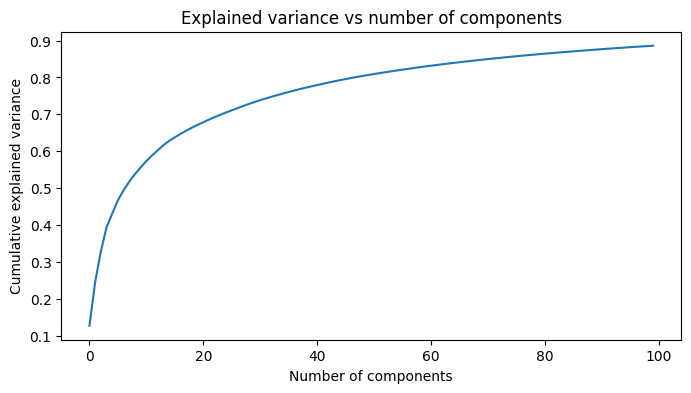

In [12]:
n_pca = 100
pca = PCA(n_components=n_pca, random_state=22).fit(X_train)
X_train_pca = pca.fit_transform(X_train)

eigenfaces = pca.components_
varianza_explicada = pca.explained_variance_ratio_

# plot explained variance (grafico continuo)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(varianza_explicada))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()


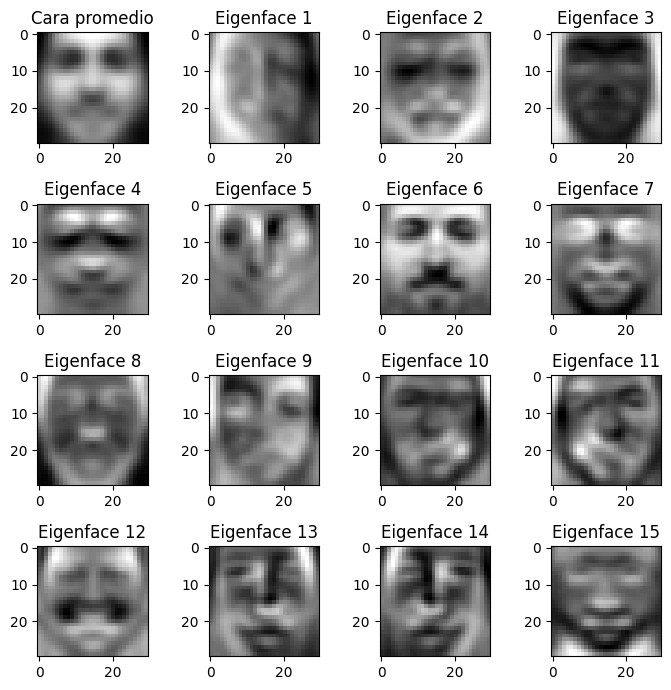

In [13]:
# Gráfico eigenfaces

fig, ax = plt.subplots(4, 4, figsize=(7, 7))

ax[0, 0].imshow(cara_promedio.reshape(30,30), cmap="gray")
ax[0, 0].set_title("Cara promedio")

for i in range(0,15): # primeras 15 pca
    ax[(i+1) // 4, (i+1) % 4].imshow(eigenfaces[i].reshape(30,30), cmap="gray")
    ax[(i+1) // 4, (i+1) % 4].set_title(f"Eigenface {i+1}")

#plot dimensions
plt.tight_layout()
plt.show()

## Entrenamiento Redes Neuronales

Realizamos las siguientes pruebas:
* Ajustamos modelo sin escalamiento de datos
* Ajustamos modelo estandarizando
* Ajustamos modelo con escalamiento min-max
* Ajustamos modelo restando cara promedio
* Ajustamos modelo sin escalamiento de datos (pero sin considerar las primeras dos CP)
* Ajustamos modelo estandarizando (pero sin considerar las primeras dos CP)
* Ajustamos modelo con escalamiento min-max (pero sin considerar las primeras dos CP)
* Ajustamos modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [14]:
# importo librerias
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from backpropagation import backpropagation_2_layers, evaluate_predictions

In [15]:
# obtener CPs
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# estandarizar CPs
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# escalamiento 0-1 CPs
scaler_min_max = MinMaxScaler()
X_train_pca_min_max = scaler_min_max.fit_transform(X_train_pca)
X_test_pca_min_max = scaler_min_max.transform(X_test_pca)

# resto cara promedio
cara_promedio_pca = pca.transform(cara_promedio.reshape(1,900)) # cuidado si cambiamos la dim de las fotos! (ahora es 30*30)
X_train_pca_menos_cara_promedio = X_train_pca - cara_promedio_pca
X_test_pca_menos_cara_promedio = X_test_pca - cara_promedio_pca

In [16]:
# Defino de antemano la catidad de neuronas por capa
hidden_size1 = 45
hidden_size2 = 26

## Prueba 1: modelo sin realizar modificaciones de las CPs

In [17]:
# obtener diccionario de pesos de la red
weights_dict = backpropagation_2_layers(X = X_train_pca, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0003904677026532996
Iteracion 20 - Error: 2.7782759899852494e-05
Iteracion 30 - Error: 1.9368889979176938e-05
Iteracion 40 - Error: 1.5918353638650013e-05
Iteracion 50 - Error: 1.3780874341453753e-05
Iteracion 60 - Error: 6.509214626520095e-06
Iteracion 70 - Error: 5.540583502482115e-06
Iteracion 80 - Error: 4.837916127230375e-06
Iteracion 90 - Error: 4.2979484309484945e-06
Iteracion 100 - Error: 3.8682810925753e-06
Iteracion 110 - Error: 3.5175588105626864e-06
Iteracion 120 - Error: 3.225527692664804e-06
Iteracion 130 - Error: 2.9784202748462353e-06
Iteracion 140 - Error: 2.766513045782547e-06
Iteracion 150 - Error: 2.582726380274404e-06
Iteracion 160 - Error: 2.421774915194699e-06
Iteracion 170 - Error: 2.2796286810507427e-06
Iteracion 180 - Error: 2.153158859553805e-06
Iteracion 190 - Error: 2.039897829587367e-06
Iteracion 200 - Error: 1.9378724195794172e-06
Iteracion 210 - Error: 1.8454854352852957e-06
Iteracion 220 - Error: 1.7614298339478475e-06
Iteracion 

,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.071387,joaquin,carlos
143,0.909663,lautaro,francoA
301,0.560414,noelia,natalia
396,0.577641,florencia,noelia
435,0.759436,lautaro,gerard
506,0.077435,noelia,lisandro
769,0.493375,lautaro,gerard
823,0.602928,juan,federicoG
944,0.891087,noelia,lisandro
1013,0.990351,lautaro,victorio


98.94837476099426

## Prueba 2: modelo estandarizando

In [18]:
# obtener diccionario de pesos de la red
weights_dict_scaled = backpropagation_2_layers(X = X_train_pca_scaled, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_scaled, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_scaled)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0014258228787647185
Iteracion 20 - Error: 0.00034698164123120697
Iteracion 30 - Error: 8.213138464723722e-05
Iteracion 40 - Error: 7.193499869990952e-05
Iteracion 50 - Error: 6.949359793862948e-05
Iteracion 60 - Error: 6.823079583769402e-05
Iteracion 70 - Error: 6.127599814660802e-05
Iteracion 80 - Error: 6.063375679721067e-05
Iteracion 90 - Error: 6.014785246260478e-05
Iteracion 100 - Error: 5.416438023818874e-05
Iteracion 110 - Error: 5.344820996826379e-05
Iteracion 120 - Error: 5.3143181650536466e-05
Iteracion 130 - Error: 5.2905109333529076e-05
Iteracion 140 - Error: 5.268198203103057e-05
Iteracion 150 - Error: 4.6582023121850486e-05
Iteracion 160 - Error: 4.626034055019142e-05
Iteracion 170 - Error: 4.610330895023034e-05
Iteracion 180 - Error: 4.5977955231073633e-05
Iteracion 190 - Error: 4.587141501643569e-05
Iteracion 200 - Error: 4.577838090364053e-05
Iteracion 210 - Error: 4.569579834544023e-05
Iteracion 220 - Error: 4.562165058338371e-05
Iteracion 230 

,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.037060,joaquin,carlos
20,0.971801,joaquin,victorio
59,0.960290,francoA,gustavo
143,0.984340,lautaro,francoA
177,0.963369,lautaro,lisandro
...,...,...,...
1966,0.186676,matias,gerard
1977,0.988708,francoA,matias
1993,0.075366,natalia,carlos
1996,0.191146,gerard,lisandro


96.89292543021033

## Prueba 3: modelo con escalamiento min-max

In [19]:
# obtener diccionario de pesos de la red
weights_dict_min_max = backpropagation_2_layers(X = X_train_pca_min_max, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_min_max, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_min_max)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.014266488441106803
Iteracion 20 - Error: 0.01643081157063624
Iteracion 30 - Error: 0.020242939576549074
Iteracion 40 - Error: 0.043853061117621626
Iteracion 50 - Error: 0.03887373722229673
Iteracion 60 - Error: 0.03751941855405972
Iteracion 70 - Error: 0.04641022725233939
Iteracion 80 - Error: 0.04466045769246678
Iteracion 90 - Error: 0.03965550837700476
Iteracion 100 - Error: 0.04063924769098802
Iteracion 110 - Error: 0.045898286725548854
Iteracion 120 - Error: 0.03465495846464815
Iteracion 130 - Error: 0.044920409957666586
Iteracion 140 - Error: 0.04250669479464381
Iteracion 150 - Error: 0.03580345874320436
Iteracion 160 - Error: 0.040171193929182954
Iteracion 170 - Error: 0.04401133619448945
Iteracion 180 - Error: 0.048989011498727836
Iteracion 190 - Error: 0.04834219349494549
Iteracion 200 - Error: 0.051148867487926186
Iteracion 210 - Error: 0.04870622423839774
Iteracion 220 - Error: 0.048973754421607625
Iteracion 230 - Error: 0.05017809149593896
Iteracion 2

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.104799,federicoG,paola
1,0.104806,federicoG,federicoR
2,0.104799,federicoG,florencia
3,0.104799,federicoG,lisandro
4,0.104799,federicoG,lautaro
...,...,...,...
2087,0.104801,federicoG,marco
2088,0.104801,federicoG,florencia
2089,0.104799,federicoG,lisandro
2090,0.104799,federicoG,carlos


6.21414913957935

## Prueba 4: modelo restando cara promedio

In [20]:
# obtener diccionario de pesos de la red
weights_dict_menos_cara_prom = backpropagation_2_layers(X = X_train_pca_menos_cara_promedio, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_menos_cara_promedio, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_menos_cara_prom)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0003547039692586598
Iteracion 20 - Error: 0.00017677846376074914
Iteracion 30 - Error: 0.0001697693572058593
Iteracion 40 - Error: 0.00016658280424128639
Iteracion 50 - Error: 0.00016471632097958254
Iteracion 60 - Error: 0.00016348044594697588
Iteracion 70 - Error: 0.00016259851457988276
Iteracion 80 - Error: 0.00016193622311151855
Iteracion 90 - Error: 0.00016142003244868513
Iteracion 100 - Error: 0.0001610061306773589
Iteracion 110 - Error: 0.00016066672317037865
Iteracion 120 - Error: 0.0001603832950446713
Iteracion 130 - Error: 0.00016014302170763635
Iteracion 140 - Error: 0.00015993673106725156
Iteracion 150 - Error: 0.0001597576855160174
Iteracion 160 - Error: 0.00015960082219589725
Iteracion 170 - Error: 0.00015946226178441419
Iteracion 180 - Error: 0.00015933898099509042
Iteracion 190 - Error: 0.00015922858835349987
Iteracion 200 - Error: 0.00015912916707770585
Iteracion 210 - Error: 0.00015903916270483374
Iteracion 220 - Error: 0.00015895730124597347
It

,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.149155,gerard,carlos
107,0.744802,lisandro,francoS
143,0.779116,lautaro,francoA
206,0.497032,florencia,noelia
396,0.547081,florencia,noelia
453,0.379405,joaquin,victorio
506,0.245297,noelia,lisandro
519,0.011880,gerard,lautaro
611,0.008741,gerard,lautaro
679,0.000989,gerard,lautaro


98.56596558317399

## Prueba 5: modelo sin realizar modificaciones de las CPs (pero sin considerar las primeras dos CP)

In [21]:
# obtener diccionario de pesos de la red
weights_dict_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0014952987522667998
Iteracion 20 - Error: 0.0005308373176494228
Iteracion 30 - Error: 0.0004970333670396552
Iteracion 40 - Error: 0.0004914183494317711
Iteracion 50 - Error: 0.0004886774506199141
Iteracion 60 - Error: 0.0004869173668014935
Iteracion 70 - Error: 0.00048567385746235584
Iteracion 80 - Error: 0.00048471540361331934
Iteracion 90 - Error: 0.0004778759552205249
Iteracion 100 - Error: 0.00047723117922084964
Iteracion 110 - Error: 0.00047673077820069044
Iteracion 120 - Error: 0.0004763197371761331
Iteracion 130 - Error: 0.00047597381813793086
Iteracion 140 - Error: 0.00047567792006237333
Iteracion 150 - Error: 0.00047542159233193655
Iteracion 160 - Error: 0.00047519722202235624
Iteracion 170 - Error: 0.00047499908204065014
Iteracion 180 - Error: 0.00047482276180842696
Iteracion 190 - Error: 0.000474664800938034
Iteracion 200 - Error: 0.00047452244224757917
Iteracion 210 - Error: 0.0004743934595820549
Iteracion 220 - Error: 0.000474276034638954
Iteracion 

,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.405408,federicoR,carlos
58,0.003934,abel,lautaro
65,0.721393,federicoR,matias
143,0.580356,lautaro,francoA
153,0.001167,lautaro,paola
...,...,...,...
1924,0.208498,lautaro,francoA
1926,0.922297,victorio,joaquin
1930,0.258477,lautaro,matias
1966,0.052156,francoS,gerard


96.9885277246654

## Prueba 6: modelo estandarizando (pero sin considerar las primeras dos CP)

In [22]:
# obtener diccionario de pesos de la red
weights_dict_scaled_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_scaled[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_scaled[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_scaled_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0045022350531695055
Iteracion 20 - Error: 0.0028668775584206486
Iteracion 30 - Error: 0.0024817908372380174
Iteracion 40 - Error: 0.002488018158362529
Iteracion 50 - Error: 0.002012168727751466
Iteracion 60 - Error: 0.001716019930599252
Iteracion 70 - Error: 0.001986946381665496
Iteracion 80 - Error: 0.001614160495194784
Iteracion 90 - Error: 0.001676551235645454
Iteracion 100 - Error: 0.0013119529172810893
Iteracion 110 - Error: 0.00200534606920681
Iteracion 120 - Error: 0.0015913635691046227
Iteracion 130 - Error: 0.0012614563470219255
Iteracion 140 - Error: 0.0017058186111912636
Iteracion 150 - Error: 0.0015556670998232672
Iteracion 160 - Error: 0.001432351132358442
Iteracion 170 - Error: 0.0019220612703251235
Iteracion 180 - Error: 0.0020947655058547736
Iteracion 190 - Error: 0.002071275127747629
Iteracion 200 - Error: 0.002348227244765003
Iteracion 210 - Error: 0.002114289715175561
Iteracion 220 - Error: 0.0021826412963718584
Iteracion 230 - Error: 0.002822

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.047393,natalia,federicoR
2,0.191845,gustavo,florencia
10,0.925848,federicoR,carlos
34,0.060139,marco,joaquin
40,0.064899,francoS,carlos
...,...,...,...
2057,0.003807,carlos,marco
2058,0.283406,paola,gustavo
2065,0.110866,joaquin,victorio
2072,0.410733,victorio,joaquin


89.5793499043977

## Prueba 7: modelo con escalamiento min-max (pero sin considerar las primeras dos CP)

In [23]:
# obtener diccionario de pesos de la red
weights_dict_min_max_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_min_max[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_min_max[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_min_max_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.02036081887747809
Iteracion 20 - Error: 0.028747906305529945
Iteracion 30 - Error: 0.030528562613751812
Iteracion 40 - Error: 0.0276190769235783
Iteracion 50 - Error: 0.016112034395701816
Iteracion 60 - Error: 0.019292485215426154
Iteracion 70 - Error: 0.022977905597235986
Iteracion 80 - Error: 0.023267970092255615
Iteracion 90 - Error: 0.02284293495594406
Iteracion 100 - Error: 0.020500811267463993
Iteracion 110 - Error: 0.027451010145288265
Iteracion 120 - Error: 0.022179468551829326
Iteracion 130 - Error: 0.025657081274222435
Iteracion 140 - Error: 0.03117959518698491
Iteracion 150 - Error: 0.03964519554980352
Iteracion 160 - Error: 0.030461670264382578
Iteracion 170 - Error: 0.020266152249472234
Iteracion 180 - Error: 0.026960824906179487
Iteracion 190 - Error: 0.020381346978320128
Iteracion 200 - Error: 0.023674282443583466
Iteracion 210 - Error: 0.019742335381639723
Iteracion 220 - Error: 0.02188840518798382
Iteracion 230 - Error: 0.02322894911015982
Itera

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.721650,matias,federicoR
2,0.343872,lautaro,florencia
5,0.652750,lautaro,carlos
10,0.041517,victorio,carlos
14,0.330178,gerard,marco
...,...,...,...
2073,0.738393,francoA,lisandro
2074,0.208597,federicoG,joaquin
2083,0.220504,francoS,federicoR
2085,0.494870,matias,florencia


70.26768642447419

## Prueba 8: modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [24]:
# obtener diccionario de pesos de la red
weights_dict_menos_cara_prom_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_menos_cara_promedio[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_menos_cara_promedio[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_menos_cara_prom_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0015254158486329471
Iteracion 20 - Error: 0.0005260669365391396
Iteracion 30 - Error: 0.0005022555810928443
Iteracion 40 - Error: 0.0004973461146765229
Iteracion 50 - Error: 0.0004887998243936298
Iteracion 60 - Error: 0.0004869182883566857
Iteracion 70 - Error: 0.00048566151671755885
Iteracion 80 - Error: 0.00048473398610008304
Iteracion 90 - Error: 0.0004840154382964475
Iteracion 100 - Error: 0.0004834399184582879
Iteracion 110 - Error: 0.00048296698971743565
Iteracion 120 - Error: 0.0004825695725587558
Iteracion 130 - Error: 0.00048222528772749805
Iteracion 140 - Error: 0.00048174456222597795
Iteracion 150 - Error: 0.0004755911159477666
Iteracion 160 - Error: 0.00047527294953492334
Iteracion 170 - Error: 0.0004750468272290432
Iteracion 180 - Error: 0.0004748592719228292
Iteracion 190 - Error: 0.00047469520861015505
Iteracion 200 - Error: 0.0004745489334960952
Iteracion 210 - Error: 0.0004744172386038365
Iteracion 220 - Error: 0.00047429784138716636
Iteracion 2

,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.735464,federicoR,carlos
65,0.127514,federicoR,matias
153,0.030946,juan,paola
163,0.008734,paola,matias
166,0.909693,francoA,lisandro
...,...,...,...
1930,0.030854,carlos,matias
1955,0.607828,carlos,francoA
1966,0.008449,florencia,gerard
1977,0.992657,francoA,matias


97.03632887189293

## Prediccion nuevas caras

## Importar imagenes para testeo prediccion nuevas caras

In [25]:
# Configuración inicial
data_dir = ("fotos_test_entrenamiento")  # Cambia esto a la ruta de tu directorio de imágenes
nombres = []
imagenes = []

# Cargar imágenes y etiquetas
for archivo in os.listdir(data_dir):
    if archivo.endswith('.jpeg') or archivo.endswith('.jpg'):
        nombre = archivo.split('_')[0].replace(".jpg","").replace(".jpeg","")
        nombre = re.sub(r'\d+', '', nombre)
        ruta_imagen = os.path.join(data_dir, archivo)
        imagen = Image.open(ruta_imagen)
        imagen = np.array(imagen.resize((30, 30)))  # Redimensionar imágenes para un tamaño uniforme
        if len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises si es necesario
        imagenes.append(imagen.flatten())
        nombres.append(nombre)

new_images_test = np.array(imagenes)
nombres_new_test = np.array(nombres)

# estand
new_images_test = new_images_test/255.0

In [26]:
greyscale_values_predict = pd.DataFrame(new_images_test)
people_names_predict = nombres_new_test.reshape(-1)

In [27]:
# definir X_new, nombres_y_new, y_new
X_new, nombres_y_new = greyscale_values_predict, people_names_predict
y_new = label_binarizer.transform(nombres_y_new)

In [28]:
print(X_new.shape)
nombres_y_new

(30, 900)


array(['federicoG', 'federicoG', 'federicoG', 'federicoG', 'federicoG',
       'federicoG', 'federicoG', 'federicoG', 'federicoG', 'federicoR',
       'federicoR', 'federicoR', 'florencia', 'florencia', 'florencia',
       'florencia', 'florencia', 'lautaro', 'lautaro', 'lautaro',
       'lautaro', 'lautaro', 'lisandro', 'lisandro', 'paola', 'paola',
       'paola', 'paola', 'paola', 'paola'], dtype='<U9')

In [29]:
# aplicar pca y escalado de datos

# obtener CPs
X_new_pca = pca.transform(X_new)

# estandarizar CPs
X_new_pca_scaled = scaler.transform(X_new_pca)

# escalamiento 0-1 CPs
X_new_pca_min_max = scaler_min_max.transform(X_new_pca)

# resto cara promedio
X_new_pca_menos_cara_promedio = X_new_pca - cara_promedio_pca

## Prueba 1:  modelo sin escalamiento de datos (solo CPs)

In [30]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.963925,federicoG,federicoG
1,0.995363,federicoG,federicoG
2,0.965224,federicoG,federicoG
3,0.767974,federicoG,federicoG
4,0.994018,federicoG,federicoG
5,0.767974,federicoG,federicoG
6,0.994018,federicoG,federicoG
7,0.965224,federicoG,federicoG
8,0.995363,federicoG,federicoG
9,0.997434,federicoR,federicoR


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.914413,natalia,federicoR
12,0.263880,gustavo,florencia
13,0.529486,gustavo,florencia
15,0.529486,gustavo,florencia
16,0.263880,gustavo,florencia
18,0.026454,gustavo,lautaro
19,0.619635,lisandro,lautaro
20,0.014906,paola,lautaro
21,0.395078,francoA,lautaro


70.0

## Prueba 2: modelo estandarizando

In [31]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_scaled, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_scaled)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.980771,federicoG,federicoG
1,0.964719,federicoG,federicoG
2,0.509999,federicoG,federicoG
3,0.884989,federicoG,federicoG
4,0.655236,federicoG,federicoG
5,0.884989,federicoG,federicoG
6,0.655236,federicoG,federicoG
7,0.509999,federicoG,federicoG
8,0.964719,federicoG,federicoG
17,0.999962,lautaro,lautaro


,Valor máximo,Nombre de la columna,Nombre verdadero
9,0.141513,francoS,federicoR
10,0.998512,natalia,federicoR
11,0.569710,francoA,federicoR
12,0.982422,gustavo,florencia
13,0.605957,gustavo,florencia
14,0.834820,gustavo,florencia
15,0.605957,gustavo,florencia
16,0.982422,gustavo,florencia
18,0.017614,victorio,lautaro
19,0.917219,lisandro,lautaro


56.666666666666664

## Prueba 3: modelo con escalamiento min-max

In [32]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_min_max, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_min_max)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.104799,federicoG,federicoG
1,0.104799,federicoG,federicoG
2,0.104799,federicoG,federicoG
3,0.104799,federicoG,federicoG
4,0.104799,federicoG,federicoG
5,0.104799,federicoG,federicoG
6,0.104799,federicoG,federicoG
7,0.104799,federicoG,federicoG
8,0.104799,federicoG,federicoG


,Valor máximo,Nombre de la columna,Nombre verdadero
9,0.104798,federicoG,federicoR
10,0.104799,federicoG,federicoR
11,0.104797,federicoG,federicoR
12,0.104799,federicoG,florencia
13,0.104799,federicoG,florencia
14,0.104813,federicoG,florencia
15,0.104799,federicoG,florencia
16,0.104799,federicoG,florencia
17,0.104799,federicoG,lautaro
18,0.104799,federicoG,lautaro


30.0

## Prueba 4: modelo restando cara promedio

In [33]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_menos_cara_promedio, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_menos_cara_prom)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.991863,federicoG,federicoG
1,0.993003,federicoG,federicoG
3,0.907390,federicoG,federicoG
4,0.938637,federicoG,federicoG
5,0.907390,federicoG,federicoG
6,0.938637,federicoG,federicoG
8,0.993003,federicoG,federicoG
9,0.999351,federicoR,federicoR
11,0.945379,federicoR,federicoR
14,0.997565,florencia,florencia


,Valor máximo,Nombre de la columna,Nombre verdadero
2,0.784329,abel,federicoG
7,0.784329,abel,federicoG
10,0.925778,natalia,federicoR
12,0.784325,noelia,florencia
13,0.078836,noelia,florencia
15,0.078836,noelia,florencia
16,0.784325,noelia,florencia
17,0.968534,victorio,lautaro
18,0.037673,lisandro,lautaro
20,0.071868,paola,lautaro


63.33333333333333

## Prueba 5: sin escalamiento de datos (pero sin considerar las primeras dos CP)

In [34]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.098150,federicoG,federicoG
1,0.999503,federicoG,federicoG
2,0.878365,federicoG,federicoG
3,0.018436,federicoG,federicoG
4,0.219945,federicoG,federicoG
5,0.018436,federicoG,federicoG
6,0.219945,federicoG,federicoG
7,0.878365,federicoG,federicoG
8,0.999503,federicoG,federicoG
9,0.998051,federicoR,federicoR


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.966904,natalia,federicoR
11,0.202176,francoA,federicoR
17,0.985649,victorio,lautaro
18,0.997575,victorio,lautaro
20,0.090037,gustavo,lautaro
21,0.065420,lisandro,lautaro


80.0

## Prueba 6: modelo estandarizando (pero sin considerar las primeras dos CP)

In [35]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_scaled[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_scaled_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.022187,federicoG,federicoG
3,0.863189,federicoG,federicoG
5,0.863189,federicoG,federicoG
8,0.022187,federicoG,federicoG
12,0.938264,florencia,florencia
13,0.999995,florencia,florencia
14,0.966007,florencia,florencia
15,0.999995,florencia,florencia
16,0.938264,florencia,florencia
17,0.013431,lautaro,lautaro


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.996128,victorio,federicoG
2,0.827394,federicoR,federicoG
4,0.955998,victorio,federicoG
6,0.955998,victorio,federicoG
7,0.827394,federicoR,federicoG
9,0.999775,francoA,federicoR
10,0.998964,natalia,federicoR
11,0.999993,francoA,federicoR
18,0.999244,victorio,lautaro
20,0.189662,marco,lautaro


60.0

## Prueba 7: modelo con escalamiento min-max (pero sin considerar las primeras dos CP)

In [36]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_min_max[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_min_max_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
12,0.983979,florencia,florencia
13,0.992826,florencia,florencia
14,0.120368,florencia,florencia
15,0.992826,florencia,florencia
16,0.983979,florencia,florencia
17,0.083343,lautaro,lautaro
18,0.393946,lautaro,lautaro
22,0.221805,lisandro,lisandro
24,0.247338,paola,paola
25,0.989024,paola,paola


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.201357,victorio,federicoG
1,0.500085,marco,federicoG
2,0.801714,gerard,federicoG
3,0.130575,marco,federicoG
4,0.097273,victorio,federicoG
5,0.130575,marco,federicoG
6,0.097273,victorio,federicoG
7,0.801714,gerard,federicoG
8,0.500085,marco,federicoG
9,0.976406,francoA,federicoR


40.0

## Prueba 8: modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [37]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_menos_cara_promedio[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_menos_cara_prom_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.017679,federicoG,federicoG
1,0.999929,federicoG,federicoG
2,0.801821,federicoG,federicoG
3,0.072074,federicoG,federicoG
5,0.072074,federicoG,federicoG
7,0.801821,federicoG,federicoG
8,0.999929,federicoG,federicoG
9,0.989332,federicoR,federicoR
12,0.929556,florencia,florencia
13,0.999761,florencia,florencia


,Valor máximo,Nombre de la columna,Nombre verdadero
4,0.627214,victorio,federicoG
6,0.627214,victorio,federicoG
10,0.608322,natalia,federicoR
11,0.134726,francoA,federicoR
17,0.979408,victorio,lautaro
18,0.993085,victorio,lautaro
20,0.331181,gustavo,lautaro
21,0.031986,natalia,lautaro
23,0.762829,joaquin,lisandro


70.0

## Guardar modelo seleccionado

In [40]:
import joblib
import pickle

GUARDAR_MODELO_SELECCIONADO = True # poner en true para guardar el modelo seleccionado

if GUARDAR_MODELO_SELECCIONADO:

    # Guardar el scaler y la PCA
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(pca, 'pca.pkl')
    joblib.dump(label_binarizer, 'label_binarizer.pkl')
    joblib.dump(scaler_min_max, 'scaler_min_max.pkl')
    joblib.dump(cara_promedio_pca, 'cara_promedio_pca.pkl')

    # Guardar el diccionario con los pesos de la red neuronal en un archivo pickle
    modelo_a_guardar = weights_dict_sin_1ras_3cps # Referencia al mejor modelo. Ej para la prueba 8 seria: weights_dict_menos_cara_prom_sin_1ras_3cps
    with open('weights_dict.pkl', 'wb') as archivo:
        pickle.dump(modelo_a_guardar, archivo)
        
    # IMPORTANTE.. mover estos objetos a "02_probar_nuevas_fotos/objetos_modelo_seleccionado"